In [1]:
%%time
#importar galeries
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
import seaborn as sns

#Valors a canviar al canviar d'any:
estació="Albuquerque"
any=2022
dies_febrer=28
excel=openpyxl.load_workbook("2022_tfg_Albuquerque.xlsx")#obrim l'excel

Wall time: 35.8 s


In [2]:
%%time
#vull agafar valors de THTA i altura a 700hPa i entre 750 i 800hPa

#llistes per després navegar per l'excel
dies=["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","31"]
mesos=["gener","febrer","març","abril","maig","juny","juliol","agost","setembre","octubre","novembre","desembre"]
mesos_31dies=["gener","març","maig","juliol","agost","octubre","desembre"]
mesos_30dies=["abril","juny","setembre","novembre"]
ab=[" Jan"," Fe"," Ma"," Apr"," May"," Ju"," Ju"," Au"," Se"," Oc"," No"," De"]

#creo l'arrays on posaré els valors de THTA i altura a 700 hPa 
THTA_00_700 = np.full(366, np.nan)
THTA_00_700[0] = 700
altura_700 = np.full(366, np.nan)
altura_700[0] = 700

#un array per valors entre 750 i 800. Per cada dia es prendran els valors d'entre 750 i 800 hPa i s'afegirà la mitjana en aquest array.
THTA_00_750_800 = np.full(366, np.nan)
THTA_00_750_800[0] = np.nan
press750800=np.arange(750.0,800.0,step=1.0)

b=0#aquest valor indicarà la columna a la que pertoca el valor d'aquell dia

for mes in mesos:#una iteració per cada mes/full de l'excel
    #print(mes)
    full=excel[mes]#agafem el full de l'excel del mes que fem
    columna=full["G"]#la columna de l'excel on hi ha indicat l'hora i el dia de la mesura
    col_press=full["B"]#la columna de l'excel amb les pressions
    
    #el valor dimes serà el nombre de dies que té el mes que toca
    if mes in mesos_31dies:
        dimes=31
    elif mes in mesos_30dies:
        dimes=30
    elif mes=="febrer":
        dimes=dies_febrer
    
    fsegüent=9#perqué no comneçi a mirar el primer dia en una fila negativa
    for i in np.arange(0,dimes):#m'ha semblat que teniem pocs loops, així que un amb una iteració per dia del mes
        #print(dies[i],"dia")
        
        valorsTHTA_750800=[]#valors del dia i hora de la temperatura dins l'interval (el buidem per posar els d'aquest dia)

        b+=1#aquest valor marca la columna on colocarà la dada dels nostres arrays amb dades
        for fila in range(fsegüent-8, full.max_row + 1):#loop amb una iteració per cela de la columna amb l'hora i el dia
            
            #en aquestes posicións mirarà si hi ha algo que indiqui que estem en el dia que volem
            celda = full["G" + str(fila)]
            celda2 = full["H" + str(fila)]
            
            #aquestes són les diferents maneres en que l'excel ens pot indicar el dia
            string_nit="00Z "+dies[i]#l'string que trobarem en l'excel per indicar aquell dia a les 00 de la nit
            string_nit2="t 00Z "+dies[i]#el mateix en altres mesos
            string_nit3="at 00Z"
            string_nit3c2=dies[i]+ab[mesos.index(mes)]
            
            #un cop trobem la casella en que indica el dia que busquem:
            if celda.value==string_nit or celda.value==string_nit2 or (celda.value==string_nit3 and celda2.value==string_nit3c2) or celda2.value==string_nit:#si a la cela hi ha aquesta string           

                c, f=openpyxl.utils.cell.coordinate_from_string(celda.coordinate)#pren la columna i fila de la cela indicant l'hora i el dia
                #ara que tenim la cela volem mirar fins on acaben les dades d'aquella hora i dia
                for fila in np.arange(f+10,f+300):#busquem en aquestes files
                    if full.cell(row=fila, column=openpyxl.utils.column_index_from_string("B")).value=="1000.0":#busquem la fila amb el valor 1000.0 de la següent mesura
                        fsegüent=fila#ens apuntem la fila
                        break
                #ara sabem que les mesures d'aquella hora i dia estan entre la fila "f" i la fila "fsegüent"
                
                for fil in np.arange(f,fsegüent):#ara fem un loop per mirar cada fila de només aquesta mesura
                    cell=full.cell(row=fil, column=openpyxl.utils.column_index_from_string("B"))#mirem la cela de columna de les pressions i fila de la iteració
                    if cell.value=="700.0":#a veure si hi ha la pressió que busquem
                        cv, fv=openpyxl.utils.cell.coordinate_from_string(cell.coordinate)#apuntem columna i fila de la cela amb la pressió que buscavem
                        pTHTA=openpyxl.utils.cell.get_column_letter(10) + str(fv)#coordenada de la THTA
                        palt=openpyxl.utils.cell.get_column_letter(3) + str(fv)#coordenada de la altura
                        if isinstance(full[pTHTA].value, str):#si el valor està presentable per l'amor de Déu
                            THTA_00_700[b]=float(full[pTHTA].value)#ens apuntem el valor en el nostre arrays de dades
                            altura_700[b]=float(full[palt].value)#ens apuntem el valor de l'altura també
                            
                            
                    if cell.value in np.array(press750800, dtype=str):#a veure si hi ha una pressió entre 750 i 800 en aquella fila
                        cv2, fv2=openpyxl.utils.cell.coordinate_from_string(cell.coordinate)#apuntem columna i fila de la cela amb la pressió que buscavem
                        pTHTA2=openpyxl.utils.cell.get_column_letter(10) + str(fv2)#coordenada de la THTA
                        if isinstance(full[pTHTA2].value, str):#si el valor està presentable per l'amor de Dé
                            valorsTHTA_750800=np.append(valorsTHTA_750800, float(full[pTHTA2].value))#ens apuntem el valor          
        
        #després de mirar el dia sencer fem mitjana dels valors d'entre 750 i 800 que hem pres i l'apuntem al nostre array
        THTA_00_750_800[b]=np.nanmean(np.array(valorsTHTA_750800, dtype=float))

C:\Users\emmas\miniconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


Wall time: 55.6 s


In [3]:
#construim l'array que ens farà d'eix x amb els dies de l'any:
dates_00=[]
dies_mesos=[0,]
a=0
for mes in mesos:
    if mes in mesos_31dies:
        dimes=31
    elif mes in mesos_30dies:
        dimes=30
    elif mes=="febrer":
        dimes=dies_febrer
    for i in np.arange(0,dimes):
        dates_00.append(mes + " " + dies[i])#per fer l'eix X de les gràfiques amb cada dia
    a+=dimes
    dies_mesos=np.append(dies_mesos,a)
print(dies_mesos)

[  0  31  59  90 120 151 181 212 243 273 304 334 365]


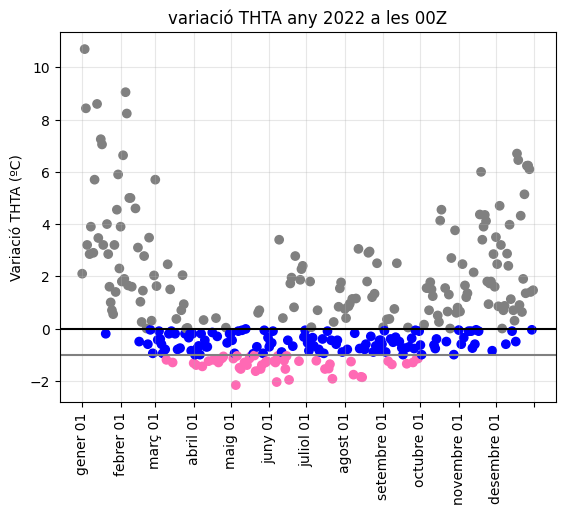

Wall time: 701 ms


In [4]:
%%time
#vaig a calcular la variació de THTA

THTA_700_750o800=THTA_00_700-THTA_00_750_800

colors = np.where(THTA_700_750o800[1:] < -1, 'hotpink', np.where(THTA_700_750o800[1:] < 0, 'blue', 'grey'))
plt.scatter(dates_00,THTA_700_750o800[1:], color=colors)

plt.axhline(y=0, color="k")
plt.axhline(y=-1, color="grey")
plt.title(f"variació THTA any {any} a les 00Z")
plt.xticks(dies_mesos,rotation=90)
plt.ylabel("Variació THTA (ºC)")
plt.grid(alpha=0.3)
plt.show()

In [5]:
#aquí veig de quins dies m'interesa mirar el diagrama de Stuve (vaig canviant els valors per anar trobant el que m'interessa)


posTHTAP6 = np.where(THTA_700_750o800 > 4)
posTHTA_1 = np.where(THTA_700_750o800 < -1.8 )
posTHTA_0 = np.where(THTA_700_750o800 < 0 )
print(posTHTA_1)

dates_00_array = np.array(dates_00)
diesTHTA_1=dates_00_array[posTHTA_1]
print(dates_00_array[posTHTA_1])
print(THTA_700_750o800[posTHTA_1])
#aquí copio l'array que he tret del programa radiosondatges que indica quins dies el NCE és menor de 3500
posNCE_3500=([  0,  19,  33,  80, 232, 278, 308, 333, 334, 335, 362, 363, 364])

#mirem quines hi ha en comú

elements_comuns = np.intersect1d(posTHTAP6, posNCE_3500)
print(posTHTA_1)
print(dates_00_array[posTHTA_1])
print(THTA_700_750o800[posTHTA_1])

positions = [0, 33, 80, 362, 363, 364]
elements = [THTA_700_750o800[i] for i in positions]
print(elements)

(array([125, 158, 168, 203, 226, 227], dtype=int64),)
['maig 06' 'juny 08' 'juny 18' 'juliol 23' 'agost 15' 'agost 16']
[-2.16666667 -2.05       -1.96666667 -1.925      -1.85       -1.86666667]
(array([125, 158, 168, 203, 226, 227], dtype=int64),)
['maig 06' 'juny 08' 'juny 18' 'juliol 23' 'agost 15' 'agost 16']
[-2.16666667 -2.05       -1.96666667 -1.925      -1.85       -1.86666667]
[nan, 1.8000000000000114, -0.7500000000000568, 6.100000000000023, 1.3999999999999773, -0.05000000000001137]
